# Asymmetric Learned Image Compression with Multi-Scale Residual Block, Importance Map, and Post-Quantization Filtering

## CSN3020 Design Credit Project 

    Ayush Abrol B20AI052

---

In [96]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import range_coder
import pywt
from keras.datasets import mnist

import os
from glob import glob
import tensorflow as tf
import tensorflow_compression as tfc
import math
import time
import scipy.special

import argparse
import sys
from absl import app
from absl.flags import argparse_flags
from PIL import Image

from range_coder import RangeEncoder, RangeDecoder, prob_to_cum_freq
import tensorflow_probability as  tfp

import cv2
from skimage import io, color, segmentation
from scipy import ndimage as ndi
from rembg import remove

import math
from bitarray import bitarray


In [2]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
print(tf.__version__)

2.14.1


In [6]:
tfd = tfp.distributions 
tfd

<module 'tensorflow_probability.python.distributions' from '/home/ayushabrol/.local/lib/python3.10/site-packages/tensorflow_probability/python/distributions/__init__.py'>

In [7]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

In [8]:
def get_image_size(input_file):
  I = Image.open(input_file)
  I_array = np.array(I)
  height_ori, width_ori, _ = np.shape(I_array)
  height = (height_ori // 64) * 64 if height_ori % 64 == 0 else (height_ori // 64 + 1) * 64
  width = (width_ori // 64) * 64 if width_ori % 64 == 0 else (width_ori // 64 + 1) * 64
  top_end = (height - height_ori) // 2
  left_end = (width - width_ori) // 2
  
  top_end = (height - height_ori) // 2
  left_end = (width - width_ori) // 2
  real_height_start = top_end
  real_height_end = top_end + height_ori
  real_width_start = left_end
  real_width_end = left_end + width_ori
  I_array_padded = np.zeros((1,height,width,3), np.uint8)
  I_array_padded[0,top_end:top_end+height_ori, left_end:left_end+width_ori,:]=I_array
  print('height_pad:', height, 'width_pad:', width)
  
  return I_array_padded,(real_height_start, real_height_end, real_width_start, real_width_end, height, width)


In [9]:
def read_png(filename):
  """Loads a PNG image file."""
  string = tf.read_file(filename)
  image = tf.image.decode_image(string, channels=3)
  image = tf.cast(image, tf.float32)
  image /= 255
  return image

def quantize_image(image):
  image = tf.round(image * 255)
  image = tf.saturate_cast(image, tf.uint8)
  return image

def write_png(filename, image):
  """Saves an image to a PNG file."""
  image = quantize_image(image)
  string = tf.image.encode_png(image)
  return tf.write_file(filename, string)


def load_image(filename):
  """Loads a PNG image file."""

  string = tf.read_file(filename)
  image = tf.image.decode_image(string, channels=3)
  image = tf.cast(image, tf.float32)
  image /= 255
  return image

def save_image(filename, image):
  """Saves an image to a PNG file."""

  image = tf.clip_by_value(image, 0, 1)
  image = tf.round(image * 255)
  image = tf.cast(image, tf.uint8)
  string = tf.image.encode_png(image)
  return tf.write_file(filename, string)

In [10]:
def residualblock(tensor, num_filters, scope="residual_block"):
  """Builds the residual block"""
  with tf.compat.v1.variable_scope(scope):
    with tf.compat.v1.variable_scope("conv0"):
      layer = tfc.SignalConv2D(
        num_filters//2, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.relu, name='signal_conv2d')
      output = layer(tensor)

    with tf.compat.v1.variable_scope("conv1"):
      layer = tfc.SignalConv2D(
        num_filters//2, (3,3), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.relu, name='signal_conv2d')
      output = layer(output)

    with tf.compat.v1.variable_scope("conv2"):
      layer = tfc.SignalConv2D(
        num_filters, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=None, name='signal_conv2d')
      output = layer(output)
      
    tensor = tensor + output
       
  return tensor

In [11]:
def residualblock_kenal(tensor, num_filters, kernel_size =3, scope="residual_block"):
  """Builds the residual block"""
  
  with tf.compat.v1.variable_scope(scope):
    with tf.compat.v1.variable_scope("conv0"):
      layer = tfc.SignalConv2D(
        num_filters//2, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.relu, name='signal_conv2d')
      output = layer(tensor)

    with tf.compat.v1.variable_scope("conv1"):
      layer = tfc.SignalConv2D(
        num_filters//2, (kernel_size,kernel_size), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.relu, name='signal_conv2d')
      output = layer(output)

    with tf.compat.v1.variable_scope("conv2"):
      layer = tfc.SignalConv2D(
        num_filters, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=None, name='signal_conv2d')
      output = layer(output)
      
    tensor = tensor + output
       
  return tensor

In [12]:
def Multiply_resblock(tensor, num_filters, kernel_size =3, scope="multiply_residual_block"):
  """Builds the residual block"""
  with tf.compat.v1.variable_scope(scope):
    trunk_branch_3 = residualblock_kenal(tensor, num_filters, 3,scope="trunk_RB_3_3")
    trunk_branch_5 = residualblock_kenal(tensor, num_filters, 5,scope="trunk_RB_5_5")
    
    
    input_1 = tf.concat([trunk_branch_3, trunk_branch_5], axis=3)
    input_2 = tf.concat([trunk_branch_5, trunk_branch_3], axis=3)
    
    with tf.compat.v1.variable_scope("input_1_conv_1x1"):
      layer = tfc.SignalConv2D(
        num_filters, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.relu, name='signal_conv2d')
      input_1 = layer(input_1)
    
    
    with tf.compat.v1.variable_scope("input_2_conv_1x1"):
      layer = tfc.SignalConv2D(
        num_filters, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.relu, name='signal_conv2d')
      input_2 = layer(input_2)
    
    
    second_trunk_branch_3 = residualblock_kenal(input_1, num_filters, 3,scope="second_trunk_RB_3_3")
    second_trunk_branch_5 = residualblock_kenal(input_2, num_filters, 5,scope="second_trunk_RB_5_5")
    
    third_input = tf.concat([second_trunk_branch_3, second_trunk_branch_5], axis=3)
    
    with tf.compat.v1.variable_scope("conv_1x1"):
      layer = tfc.SignalConv2D(
        num_filters, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=None, name='signal_conv2d')
      output = layer(third_input)
    tensor = tensor + output
  return tensor

In [13]:
def NonLocalAttentionBlock(input_x, num_filters, scope="NonLocalAttentionBlock"):
  """Builds the non-local attention block"""
  with tf.compat.v1.variable_scope(scope):
    trunk_branch = residualblock(input_x, num_filters, scope="trunk_RB_0")
    trunk_branch = residualblock(trunk_branch, num_filters, scope="trunk_RB_1")
    trunk_branch = residualblock(trunk_branch, num_filters, scope="trunk_RB_2")
    
    attention_branch = residualblock(input_x, num_filters, scope="attention_RB_0")
    attention_branch = residualblock(attention_branch, num_filters, scope="attention_RB_1")
    attention_branch = residualblock(attention_branch, num_filters, scope="attention_RB_2")

    with tf.compat.v1.variable_scope("conv_1x1"):
      layer = tfc.SignalConv2D(
        num_filters, (1,1), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=None, name='signal_conv2d')
      attention_branch = layer(attention_branch)
    attention_branch = tf.sigmoid(attention_branch)

  tensor = input_x + tf.multiply(attention_branch, trunk_branch)
  return tensor

In [14]:
def analysis_transform(tensor, num_filters):
  """Builds the analysis transform."""

  kernel_size = 3
  #Use three 3x3 filters to replace one 9x9
  
  with tf.compat.v1.variable_scope("analysis"):

    # Four down-sampling blocks
    for i in range(4):
      if i > 0:
        # with tf.variable_scope("Block_" + str(i) + "_layer_0"):
          # layer = tfc.SignalConv2D(
            # num_filters, (kernel_size, kernel_size), corr=True, strides_down=1, padding="same_zeros",
            # use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
          # tensor2 = layer(tensor)

        # with tf.variable_scope("Block_" + str(i) + "_layer_1"):
          # layer = tfc.SignalConv2D(
              # num_filters, (kernel_size, kernel_size), corr=True, strides_down=1, padding="same_zeros",
              # use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
          # tensor2 = layer(tensor2)
        
        # tensor = tensor + tensor2
        tensor = Multiply_resblock(tensor, num_filters, kernel_size =3, scope="multiply_residual_block"+str(i))


      if i < 3:
        with tf.compat.v1.variable_scope("Block_" + str(i) + "_shortcut"):
          shortcut = tfc.SignalConv2D(num_filters, (1, 1), corr=True, strides_down=2, padding="same_zeros",
                                      use_bias=True, activation=None, name='signal_conv2d')
          shortcut_tensor = shortcut(tensor)

        with tf.compat.v1.variable_scope("Block_" + str(i) + "_layer_2"):
          layer = tfc.SignalConv2D(
              num_filters, (kernel_size, kernel_size), corr=True, strides_down=2, padding="same_zeros",
              use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
          tensor = layer(tensor)

        with tf.compat.v1.variable_scope("Block_" + str(i) + "_layer_3"):
          layer = tfc.SignalConv2D(
            num_filters, (kernel_size, kernel_size), corr=True, strides_down=1, padding="same_zeros",
            use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
          tensor = layer(tensor)
          
          tensor = tensor + shortcut_tensor

        if i == 1:
          #Add one NLAM
          tensor = NonLocalAttentionBlock(tensor, num_filters, scope="NLAB_0")
          

      else:
        with tf.compat.v1.variable_scope("Block_" + str(i) + "_layer_2"):
          layer = tfc.SignalConv2D(
            num_filters, (kernel_size, kernel_size), corr=True, strides_down=2, padding="same_zeros",
            use_bias=False, activation=None, name='signal_conv2d') 
          tensor_out = layer(tensor)
          
          
        with tf.compat.v1.variable_scope("Heatmap"):
          layer = tfc.SignalConv2D(
            num_filters, (kernel_size, kernel_size), corr=True, strides_down=2, padding="same_zeros",
            use_bias=True, activation=tf.nn.relu, name='signal_conv2d') 
          tensor_heatin = layer(tensor)
          tensor_heatmap = residualblock(tensor_heatin,num_filters)
          tensor_heatmap = residualblock(tensor_heatmap,num_filters)
          tensor_heatmap = residualblock(tensor_heatmap,num_filters)
          tensor_heatmap = tensor_heatin + tensor_heatmap
          tensor_heatmap = tf.math.tanh(tensor_heatmap)
          tensor_heatmap = tf.nn.softsign(tensor_heatmap)

        #Add one NLAM
        tensor_out = NonLocalAttentionBlock(tensor_out, num_filters, scope="NLAB_1")
        tensor = tensor_heatmap*tensor_out

    return tensor

In [15]:
def hyper_analysis(tensor, num_filters):
  """Build the analysis transform in hyper"""

  with tf.compat.v1.variable_scope("hyper_analysis"):
    with tf.compat.v1.variable_scope("layer_0"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    #One 5x5 is replaced by two 3x3 filters     
    with tf.compat.v1.variable_scope("layer_1"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_2"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=True, strides_down=2, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    #One 5x5 is replaced by two 3x3 filters 
    with tf.compat.v1.variable_scope("layer_3"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=True, strides_down=1, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_4"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=True, strides_down=2, padding="same_zeros",
        use_bias=True, activation=None, name='signal_conv2d')
      tensor = layer(tensor)

    return tensor

In [16]:
def synthesis_transform(tensor, num_filters):
  """Builds the synthesis transform."""

  kernel_size = 3
  #Use four 3x3 filters to replace one 9x9
  
  with tf.variable_scope("synthesis"):

    # Four up-sampling blocks
    for i in range(4):
      if i == 0:
        #Add one NLAM
        tensor = NonLocalAttentionBlock(tensor, num_filters, scope="NLAB_0")

      if i == 2:
        #Add one NLAM
        tensor = NonLocalAttentionBlock(tensor, num_filters, scope="NLAB_1")
        
      # with tf.variable_scope("Block_" + str(i) + "_layer_0"):
        # layer = tfc.SignalConv2D(
          # num_filters, (kernel_size, kernel_size), corr=False, strides_up=1, padding="same_zeros",
          # use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
        # tensor2 = layer(tensor)

      # with tf.variable_scope("Block_" + str(i) + "_layer_1"):
        # layer = tfc.SignalConv2D(
          # num_filters, (kernel_size, kernel_size), corr=False, strides_up=1, padding="same_zeros",
          # use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
        # tensor2 = layer(tensor2)
        # tensor = tensor + tensor2
        tensor = Multiply_resblock(tensor, num_filters, kernel_size =3, scope="multiply_residual_block"+str(i))


      if i <3:
        with tf.variable_scope("Block_" + str(i) + "_shortcut"):

          # Use Sub-Pixel to replace deconv.
          shortcut = tfc.SignalConv2D(num_filters*4, (1, 1), corr=False, strides_up=1, padding="same_zeros",
                                      use_bias=True, activation=None, name='signal_conv2d')
          shortcut_tensor = shortcut(tensor)
          shortcut_tensor = tf.depth_to_space(shortcut_tensor, 2)

        with tf.variable_scope("Block_" + str(i) + "_layer_2"):

          # Use Sub-Pixel to replace deconv.
          layer = tfc.SignalConv2D(num_filters*4, (kernel_size, kernel_size), corr=False, strides_up=1, padding="same_zeros",
                                   use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
          tensor = layer(tensor)
          tensor = tf.depth_to_space(tensor, 2)         
          
        with tf.variable_scope("Block_" + str(i) + "_layer_3"):
          layer = tfc.SignalConv2D(
            num_filters, (kernel_size, kernel_size), corr=False, strides_up=1, padding="same_zeros",
            use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
          tensor = layer(tensor)
          
          tensor = tensor + shortcut_tensor

      else:
        with tf.variable_scope("Block_" + str(i) + "_layer_2"):
          
          # Use Sub-Pixel to replace deconv.
          layer = tfc.SignalConv2D(12, (kernel_size, kernel_size), corr=False, strides_up=1, padding="same_zeros",
                                   use_bias=True, activation=None, name='signal_conv2d')
          tensor = layer(tensor)
          tensor = tf.depth_to_space(tensor, 2)
          
    return tensor

In [17]:
def hyper_synthesis(tensor, num_filters):
  """Builds the hyper synthesis transform"""

  with tf.compat.v1.variable_scope("hyper_synthesis", reuse=tf.AUTO_REUSE):
    #One 5x5 is replaced by two 3x3 filters
    with tf.variable_scope("layer_0"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=False, strides_up = 1, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_1"):
      layer = tfc.SignalConv2D(
        num_filters, (3, 3), corr=False, strides_up = 2, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    #One 5x5 is replaced by two 3x3 filters
    with tf.compat.v1.variable_scope("layer_2"):
      layer = tfc.SignalConv2D(
        num_filters*1.5, (3, 3), corr=False, strides_up = 1, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_3"):
      layer = tfc.SignalConv2D(
        num_filters*1.5, (3, 3), corr=False, strides_up = 2, padding="same_zeros",
        use_bias=True, activation=tf.nn.leaky_relu, name='signal_conv2d')
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_4"):
      layer = tfc.SignalConv2D(
        num_filters*2, (3, 3), corr=False, strides_up = 1, padding="same_zeros",
        use_bias=True, activation=None, name='signal_conv2d')
      tensor = layer(tensor)

    return tensor

In [18]:
def masked_conv2d(
    inputs,
    num_outputs,
    kernel_shape, # [kernel_height, kernel_width]
    mask_type, # None, "A" or "B",
    strides=[1, 1], # [column_wise_stride, row_wise_stride]
    padding="SAME",
    activation_fn=None,
    weights_initializer=tf.keras.initializers.GlorotUniform(),
    weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(),
    biases_regularizer=None,
    scope="masked"):
  
  with tf.compat.v1.variable_scope(scope):
    mask_type = mask_type.lower()
    batch_size, height, width, channel = inputs.get_shape().as_list()

    kernel_h, kernel_w = kernel_shape
    stride_h, stride_w = strides

    assert kernel_h % 2 == 1 and kernel_w % 2 == 1, \
      "kernel height and width should be odd number"

    center_h = kernel_h // 2
    center_w = kernel_w // 2

    weights_shape = [kernel_h, kernel_w, channel, num_outputs]
    weights = tf.get_variable("weights", weights_shape,
      tf.float32, weights_initializer, weights_regularizer)

    if mask_type is not None:
      mask = np.ones(
        (kernel_h, kernel_w, channel, num_outputs), dtype=np.float32)

      mask[center_h, center_w+1: ,: ,:] = 0.
      mask[center_h+1:, :, :, :] = 0.

      if mask_type == 'a':
        mask[center_h,center_w,:,:] = 0.

      weights *= tf.constant(mask, dtype=tf.float32)
      tf.add_to_collection('conv2d_weights_%s' % mask_type, weights)

    outputs = tf.nn.conv2d(inputs,
        weights, [1, stride_h, stride_w, 1], padding=padding, name='outputs')
    tf.add_to_collection('conv2d_outputs', outputs)

    if biases_initializer != None:
      biases = tf.get_variable("biases", [num_outputs,],
          tf.float32, biases_initializer, biases_regularizer)
      outputs = tf.nn.bias_add(outputs, biases, name='outputs_plus_b')

    if activation_fn:
      outputs = activation_fn(outputs, name='outputs_with_fn')

    return outputs

In [19]:
def entropy_parameter(tensor, inputs, num_filters, training):
  """tensor: the output of hyper autoencoder (phi) to generate the mean and variance
     inputs: the variable needs to be encoded. (y)
  """
  with tf.compat.v1.variable_scope("entropy_parameter", reuse=tf.AUTO_REUSE):

    half = tf.constant(.5)

    if training:
      noise = tf.random_uniform(tf.shape(inputs), -half, half)
      values = tf.add_n([inputs, noise])
      
      

    else: #inference
      #if inputs is not None: #compress
      values = tf.round(inputs)
        

    masked = masked_conv2d(values, num_filters*2, [5, 5], "A", scope='masked')
    tensor = tf.concat([masked, tensor], axis=3)
      

    with tf.compat.v1.variable_scope("layer_0"):
      layer = tfc.SignalConv2D(
          640, (1, 1), corr=True, strides_down=1, padding="same_zeros",
          use_bias=True, activation=tf.nn.leaky_relu)
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_1"):
      layer = tfc.SignalConv2D(
          640, (1, 1), corr=True, strides_down=1, padding="same_zeros",
          use_bias=True, activation=tf.nn.leaky_relu)
      tensor = layer(tensor)

    with tf.compat.v1.variable_scope("layer_2"):
      layer = tfc.SignalConv2D(
          num_filters*9, (1, 1), corr=True, strides_down=1, padding="same_zeros",
          use_bias=False, activation=None)
      tensor = layer(tensor)


    #=========Gaussian Mixture Model=========
    prob0, mean0, scale0, prob1, mean1, scale1, prob2, mean2, scale2 = \
             tf.split(tensor, num_or_size_splits=9, axis = 3)
    scale0 = tf.abs(scale0)
    scale1 = tf.abs(scale1)
    scale2 = tf.abs(scale2)



    probs = tf.stack([prob0, prob1, prob2], axis=-1)
    probs = tf.nn.softmax(probs, axis=-1)
  
    # To merge them together
    means = tf.stack([mean0, mean1, mean2], axis=-1)
    variances = tf.stack([scale0, scale1, scale2], axis=-1)

    # =======================================
    ###cancel note
    #Calculate the likelihoods for inputs
    #if inputs is not None:
    if training:

      dist_0 = tfd.Normal(loc = mean0, scale = scale0, name='dist_0')
      dist_1 = tfd.Normal(loc = mean1, scale = scale1, name='dist_1')
      dist_2 = tfd.Normal(loc = mean2, scale = scale2, name='dist_2')

      #=========Gaussian Mixture Model=========
      likelihoods_0 = dist_0.cdf(values + half) - dist_0.cdf(values - half)
      likelihoods_1 = dist_1.cdf(values + half) - dist_1.cdf(values - half)
      likelihoods_2 = dist_2.cdf(values + half) - dist_2.cdf(values - half)

      likelihoods = probs[:,:,:,:,0]*likelihoods_0 + probs[:,:,:,:,1]*likelihoods_1 + probs[:,:,:,:,2]*likelihoods_2

      # =======REVISION: Robust version ==========
      edge_min = probs[:,:,:,:,0]*dist_0.cdf(values + half) + \
                 probs[:,:,:,:,1]*dist_1.cdf(values + half) + \
                 probs[:,:,:,:,2]*dist_2.cdf(values + half)
      
      edge_max = probs[:,:,:,:,0]* (1.0 - dist_0.cdf(values - half)) + \
                 probs[:,:,:,:,1]* (1.0 - dist_1.cdf(values - half)) + \
                 probs[:,:,:,:,2]* (1.0 - dist_2.cdf(values - half))
      likelihoods = tf.where(values < -254.5, edge_min, tf.where(values > 255.5, edge_max, likelihoods))

      
      likelihood_lower_bound = tf.constant(1e-6)
      likelihood_upper_bound = tf.constant(1.0)
      likelihoods = tf.minimum(tf.maximum(likelihoods, likelihood_lower_bound), likelihood_upper_bound)
      
    else:
      #values = None
      likelihoods = None
        
  return values, likelihoods, means, variances, probs

In [20]:
import compressai

/home/ayushabrol/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [21]:
def compress(input, output, num_filters, checkpoint_dir):

    start = time.time()
    # tf.set_random_seed(1)
    # tf.reset_default_graph()
      
      
      #with tf.device('/cpu:0'):
        # Load input image and add batch dimension.
        
    #x = load_image(input)
    #print("x shape is {}".format(x.get_shape().as_list()))
    images_info = get_image_size(input)
    images_padded_numpy, size = images_info
    print("the size is {}".format(len(size)))
    real_height_start, real_height_end, real_width_start, real_width_end, height, width = size
    with tf.name_scope('Data'):
      images_padded = tf.compat.v1.placeholder(tf.float32, shape=(1, height, width, 3), name='images_ori')
      x = images_padded
      x_shape = tf.shape(x)
    y = analysis_transform(x, num_filters)

    # Build a hyper autoencoder
    z = hyper_analysis(y, num_filters)
    # entropy_bottleneck = compressai.entropy_models.EntropyBottleneck(channels=num_filters)
    entropy_bottleneck = tfc.entropy_models.PowerLawEntropyModel(2, alpha=0.01, bottleneck_dtype=None)
    string = entropy_bottleneck.compress(z)
    string = tf.squeeze(string, axis=0)
    #Convert z to a tensor
    # z = tf.expand_dims(z, 0)
    z_tilde, z_likelihoods = entropy_bottleneck(z, training=False)

    # To decompress the z_tilde back to avoid the inconsistence error
    string_rec = tf.expand_dims(string, 0)
    z_tilde = entropy_bottleneck.decompress(string_rec, tf.shape(z)[1:], channels=num_filters)

    phi = hyper_synthesis(z_tilde, num_filters)


    # REVISION： for Gaussian Mixture Model (GMM), use window-based fast implementation    
    #y = tf.clip_by_value(y, -255, 256)
    y_hat = tf.round(y)


    #tiny_y = tf.placeholder(dtype=tf.float32, shape= [1] + [5] + [5] + [num_filters])
    #tiny_phi = tf.placeholder(dtype=tf.float32, shape= [1] + [5] + [5] + [num_filters*2]) 
    #_, _, y_means, y_variances, y_probs = entropy_parameter(tiny_phi, tiny_y, num_filters, training=False)
    #_, _, y_means, y_variances, y_probs, y_probs_lap, y_probs_log, y_probs_mix = entropy_parameter(phi, y, num_filters, training=False)
    _, _, y_means, y_variances, y_probs = entropy_parameter(phi, y, num_filters, training=False)
    
    x_hat = synthesis_transform(y_hat, num_filters)


    num_pixels = tf.to_float(tf.reduce_prod(tf.shape(x)[:-1]))
    #x_hat = x_hat[0, :tf.shape(x)[1], :tf.shape(x)[2], :]

    #op = save_image('temp/temp.png', x_hat)

    # Mean squared error across pixels.
    x_hat = tf.clip_by_value(x_hat, 0, 1)
    x_hat = tf.round(x_hat * 255)
    x_ori = x[:, real_height_start:real_height_end, real_width_start:real_width_end, :]
    x_hat = x_hat[:, real_height_start:real_height_end, real_width_start:real_width_end, :]
    mse = tf.reduce_mean(tf.squared_difference(x_ori, x_hat))


    with tf.Session() as sess:
      print(tf.trainable_variables())
      sess.run(tf.global_variables_initializer())
      # Load the latest model checkpoint, get the compressed string and the tensor
      # shapes.
      latest = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir)
      
      # latest = "models/model-1399000" #lambda = 14
        
      # print(latest)
      # tf.train.Saver().restore(sess, save_path=latest)
      
      
      vars_restore = [var for var in tf.global_variables()]
      saver_0 = tf.train.Saver(vars_restore)
      print(f'Loading learned model from checkpoint {checkpoint_dir}')
      saver_0.restore(sess, checkpoint_dir)

      
      #y_means, y_variances, y_probs
      y_means_values, y_variances_values, y_probs_values,string, x_shape, y_shape, num_pixels, y_hat_value, phi_value = \
              sess.run([y_means, y_variances, y_probs, string, tf.shape(x), tf.shape(y), num_pixels, y_hat, phi],feed_dict={images_padded:images_padded_numpy/255.0})
      

      
      minmax = np.maximum(abs(y_hat_value.max()), abs(y_hat_value.min()))
      minmax = int(np.maximum(minmax, 1))
      #num_symbols = int(2 * minmax + 3)
      print(minmax)
      #print(num_symbols)
      
      # Fast implementations by only encoding non-zero channels with 128/8 = 16bytes overhead
      flag = np.zeros(y_shape[3], dtype=np.int)
      
      for ch_idx in range(y_shape[3]):
        if np.sum(abs(y_hat_value[:, :,:, ch_idx])) > 0:
          flag[ch_idx] = 1

      non_zero_idx = np.squeeze(np.where(flag == 1))
      
      print("the zero numbers is {}".format(num_filters-len(non_zero_idx)))
      num = np.packbits(np.reshape(flag, [8, y_shape[3]//8]))

      # ============== encode the bits for z===========
      if os.path.exists(output):
        os.remove(output)

      fileobj = open(output, mode='wb')
      fileobj.write(np.array(x_shape[1:-1], dtype=np.uint16).tobytes())
      fileobj.write(np.array([len(string), minmax], dtype=np.uint16).tobytes())
      fileobj.write(np.array(num, dtype=np.uint8).tobytes())
      fileobj.write(string)
      fileobj.close()



      # ============ encode the bits for y ==========
      print("INFO: start encoding y")
      encoder = RangeEncoder(output[:-4] + '.bin')
      samples = np.arange(0, minmax*2+1)
      TINY = 1e-10

       

      kernel_size = 5
      pad_size = (kernel_size - 1)//2
      
      
      
      padded_y = np.pad(y_hat_value, ((0, 0), (pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'constant',
                                 constant_values=((0., 0.), (0., 0.), (0., 0.), (0., 0.)))
      padded_phi = np.pad(phi_value, ((0, 0), (pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'constant',
                                 constant_values=((0., 0.), (0., 0.), (0., 0.), (0., 0.)))

      
      for h_idx in range(y_shape[1]):
        for w_idx in range(y_shape[2]):          

          
          extracted_y = padded_y[:, h_idx: h_idx+kernel_size, w_idx:w_idx+kernel_size, :]
          extracted_phi = padded_phi[:, h_idx: h_idx+kernel_size, w_idx:w_idx+kernel_size, :]

          
          # y_means_values, y_variances_values, y_probs_values = \
                          # sess.run([y_means, y_variances, y_probs], \
                                   # feed_dict={images_padded:images_padded_numpy/255.0, tiny_y: extracted_y, tiny_phi: extracted_phi})         
                                   
          # y_means_values, y_variances_values, y_probs_values, y_probs_lap_values, y_probs_log_values, y_probs_mix_values = \
                          # sess.run([y_means, y_variances, y_probs, y_probs_lap, y_probs_log, y_probs_mix], \
                                   # feed_dict={tiny_y: extracted_y, tiny_phi: extracted_phi})  

          
          
          for i in range(len(non_zero_idx)):
            ch_idx = non_zero_idx[i]
            
            # mu = y_means_values[0, pad_size, pad_size, ch_idx, :] + minmax
            # sigma = y_variances_values[0, pad_size, pad_size, ch_idx, :]
            # weight = y_probs_values[0, pad_size, pad_size, ch_idx, :]
            
            # mu = y_means_values[0, pad_size, pad_size, ch_idx, :] + minmax
            # sigma = y_variances_values[0, pad_size, pad_size, ch_idx, :]
            # weight = y_probs_values[0, pad_size, pad_size, ch_idx, :]
            # weight_lap = y_probs_lap_values[0, pad_size, pad_size, ch_idx, :]
            # weight_log = y_probs_log_values[0, pad_size, pad_size, ch_idx, :]
            # weight_mix = y_probs_mix_values[0, pad_size, pad_size, ch_idx, :]
            
            mu = y_means_values[0, h_idx, w_idx, ch_idx, :] + minmax
            sigma = y_variances_values[0, h_idx, w_idx, ch_idx, :]
            weight = y_probs_values[0, h_idx, w_idx, ch_idx, :]
            # weight_lap = y_probs_lap_values[0, h_idx, w_idx, ch_idx, :]
            # weight_log = y_probs_log_values[0, h_idx, w_idx, ch_idx, :]
            # weight_mix = y_probs_mix_values[0, h_idx, w_idx, ch_idx, :]

            start00 = time.time()

            # Calculate the pmf/cdf            
            pmf = (0.5 * (1 + scipy.special.erf((samples + 0.5 - mu[0]) / ((sigma[0] + TINY) * 2 ** 0.5))) - \
                   0.5 * (1 + scipy.special.erf((samples - 0.5 - mu[0]) / ((sigma[0] + TINY) * 2 ** 0.5)))) * weight[0] + \
                  (0.5 * (1 + scipy.special.erf((samples + 0.5 - mu[1]) / ((sigma[1] + TINY) * 2 ** 0.5))) - \
                   0.5 * (1 + scipy.special.erf((samples - 0.5 - mu[1]) / ((sigma[1] + TINY) * 2 ** 0.5)))) * weight[1] +\
                  (0.5 * (1 + scipy.special.erf((samples + 0.5 - mu[2]) / ((sigma[2] + TINY) * 2 ** 0.5))) - \
                   0.5 * (1 + scipy.special.erf((samples - 0.5 - mu[2]) / ((sigma[2] + TINY) * 2 ** 0.5)))) * weight[2]

            '''
            # Add the tail mass
            pmf[0] += 0.5 * (1 + scipy.special.erf(( -0.5 - mu[0]) / ((sigma[0] + TINY) * 2 ** 0.5))) * weight[0] + \
                      0.5 * (1 + scipy.special.erf(( -0.5 - mu[1]) / ((sigma[1] + TINY) * 2 ** 0.5))) * weight[1] + \
                      0.5 * (1 + scipy.special.erf(( -0.5 - mu[2]) / ((sigma[2] + TINY) * 2 ** 0.5))) * weight[2]
                      
            pmf[-1] += (1. - 0.5 * (1 + scipy.special.erf((minmax*2 + 0.5 - mu[0]) / ((sigma[0] + TINY) * 2 ** 0.5)))) * weight[0] + \
                       (1. - 0.5 * (1 + scipy.special.erf((minmax*2 + 0.5 - mu[1]) / ((sigma[1] + TINY) * 2 ** 0.5)))) * weight[1] + \
                       (1. - 0.5 * (1 + scipy.special.erf((minmax*2 + 0.5 - mu[2]) / ((sigma[2] + TINY) * 2 ** 0.5)))) * weight[2]
            '''
            
            # To avoid the zero-probability            
            pmf_clip = np.clip(pmf, 1.0/65536, 1.0)
            pmf_clip = np.round(pmf_clip / np.sum(pmf_clip) * 65536)
            cdf = list(np.add.accumulate(pmf_clip))
            cdf = [0] + [int(i) for i in cdf]
                      
            symbol = np.int(y_hat_value[0, h_idx, w_idx, ch_idx] + minmax )
            encoder.encode([symbol], cdf)


            

      encoder.close()

      size_real = os.path.getsize(output) + os.path.getsize(output[:-4] + '.bin')
      
      bpp_real = (os.path.getsize(output) + os.path.getsize(output[:-4] + '.bin'))* 8 / num_pixels
      bpp_side = (os.path.getsize(output))* 8 / num_pixels
      

      end = time.time()
      print("Time : {:0.3f}".format(end-start))

      psnr = sess.run(tf.image.psnr(x_hat, x_ori*255, 255),feed_dict={images_padded:images_padded_numpy/255.0})
      msssim = sess.run(tf.image.ssim_multiscale(x_hat, x_ori*255, 255),feed_dict={images_padded:images_padded_numpy/255.0})
      
      print("Actual bits per pixel for this image: {:0.4}".format(bpp_real))
      print("Side bits per pixel for z: {:0.4}".format(bpp_side))
      print("PSNR (dB) : {:0.4}".format(psnr[0]))
      print("MS-SSIM : {:0.4}".format(msssim[0]))
      
      return bpp_real, (end-start), psnr[0], msssim[0]

In [22]:
def overall_performance(metrics_list):
  psnr_rgb_list = []
  psnr_y_list = []
  psnr_u_list = []
  psnr_v_list = []
  msssim_rgb_list = []
  msssim_y_list = []
  bpp_list = []
  for metrics_item in metrics_list:
    psnr_rgb_list.append(metrics_item[0])
    psnr_y_list.append(metrics_item[1][0])
    psnr_u_list.append(metrics_item[1][1])
    psnr_v_list.append(metrics_item[1][2])
    msssim_rgb_list.append(metrics_item[2])
    msssim_y_list.append(metrics_item[3])
    bpp_list.append(metrics_item[4])
  bpp_avg = np.mean(bpp_list)
  RGB_MSE_avg = np.mean([255. ** 2 / pow(10, PSNR / 10) for PSNR in psnr_rgb_list])
  RGB_PSNR_avg = 10 * np.log10(255. ** 2 / RGB_MSE_avg)
  Y_MSE_avg = np.mean([255 ** 2 / pow(10, PSNR / 10) for PSNR in psnr_y_list])
  Y_PSNR_avg = 10 * np.log10(255 ** 2 / Y_MSE_avg)
  U_MSE_avg = np.mean([255 ** 2 / pow(10, PSNR / 10) for PSNR in psnr_u_list])
  U_PSNR_avg = 10 * np.log10(255 ** 2 / U_MSE_avg)
  V_MSE_avg = np.mean([255 ** 2 / pow(10, PSNR / 10) for PSNR in psnr_v_list])
  V_PSNR_avg = 10 * np.log10(255 ** 2 / V_MSE_avg)
  yuv_psnr_avg = 6.0/8.0*Y_PSNR_avg + 1.0/8.0*U_PSNR_avg + 1.0/8.0*V_PSNR_avg
  msssim_rgb_avg = np.mean(msssim_rgb_list)
  msssim_y_avg = np.mean(msssim_y_list)

  print("overall performance")
  print("RGB PSNR (dB): {:0.2f}".format(RGB_PSNR_avg))
  print("YUV444 PSNR (dB): {:0.2f}".format(yuv_psnr_avg))
  print("RGB Multiscale SSIM: {:0.4f}".format(msssim_rgb_avg))
  print("RGB Multiscale SSIM (dB): {:0.2f}".format(-10 * np.log10(1 - msssim_rgb_avg)))
  print("Y Multiscale SSIM: {:0.4f}".format(msssim_y_avg))
  print("Y Multiscale SSIM (dB): {:0.2f}".format(-10 * np.log10(1 - msssim_y_avg)))
  print("Actual bits per pixel: {:0.4f}\n".format(bpp_avg))

In [24]:
args = {
    "autoregressive": False,
    "num_filters": 192,
    "restore_path": None,
    "checkpoint_dir": "checkpoint/",
    "if_weight": 0.0,
    "command": "train", # or encode or decode
    "train_root_dir": "kodak/",
    "batchsize": 1,
    "patchsize": 256,
    "lossWeight": 0,
    "lambda": 0.01,
    "last_step": 1500000,
    "lr": 1e-4,
    "lr_scheduling": True,
    "preprocess_threads": 16,
    "input_file": "./kodak/kodim01.png",
    "output_file": None
}

In [26]:
checkpoint_dir = args["checkpoint_dir"]
path = args["train_root_dir"]
print(path)

kodak/


In [27]:
def encoder_main():
  eval_bpp_list = []
  bpp_real_list = []
  time_list = []
  psnr_list = []
  msssim_list = []
  save_image_name_path = checkpoint_dir.split('/')[-2]
  print("AYUSH", save_image_name_path)
  if not os.path.isdir('./'+save_image_name_path):
    os.makedirs('./'+save_image_name_path)
    
  for image_file in glob(path+'*.png'):
    print(image_file[:])
    image_name_path = image_file.split('/')[-1]
    input = image_file
    output = save_image_name_path+'/'+image_name_path + '.npz'
    print(input)
    print(output)
    #output = 'images/'
    num_filters = 256
    #checkpoint_dir = 'models'    
    bpp_real, time,  psnr, msssim = compress(input, output, num_filters, checkpoint_dir)
    #decompress(input, output, num_filters, checkpoint_dir)
    #eval_bpp_list.append(eval_bpp)
    bpp_real_list.append(bpp_real)
    time_list.append(time)
    psnr_list.append(psnr)
    msssim_list.append(msssim)

  print("\n")
  print("RGB PSNR (dB): {:0.2f}".format(np.mean(psnr_list)))
  print("RGB Multiscale SSIM: {:0.4f}".format(np.mean(msssim_list)))
  print("RGB Multiscale SSIM (dB): {:0.2f}".format(-10 * np.log10(1 - np.mean(msssim_list))))
  #print("Information content in bpp: {:0.4f}".format(np.mean(eval_bpp_list)))
  print("Actual bits per pixel: {:0.4f}".format(np.mean(bpp_real_list)))
  print("the average time is {:0.4f}".format(np.mean(time_list)))

In [28]:
def decoder_main():
  eval_bpp_list = []
  bpp_real_list = []
  time_list = []
  psnr_list = []
  msssim_list = []
  save_image_name_path = checkpoint_dir.split('/')[-2]
  print(save_image_name_path)
  if not os.path.isdir('./'+save_image_name_path):
    os.makedirs('./'+save_image_name_path)
    
  for image_file in glob(path+'*.png'):
    print(image_file[:])
    image_name_path = image_file.split('/')[-1]
    input = image_file
    output = save_image_name_path+image_name_path + '.npz'
    print(input)
    print(output)
    #output = 'images/'
    num_filters = 128
    #checkpoint_dir = 'models'    
    bpp_real, time,  psnr, msssim = compress(input, output, num_filters, checkpoint_dir)
    #decompress(input, output, num_filters, checkpoint_dir)
    #eval_bpp_list.append(eval_bpp)
    # bpp_real_list.append(bpp_real)
    # time_list.append(time)
    # psnr_list.append(psnr)
    # msssim_list.append(msssim)
  print("\n")
  print("RGB PSNR (dB): {:0.2f}".format(np.mean(psnr_list)))
  print("RGB Multiscale SSIM: {:0.4f}".format(np.mean(msssim_list)))
  print("RGB Multiscale SSIM (dB): {:0.2f}".format(-10 * np.log10(1 - np.mean(msssim_list))))
  #print("Information content in bpp: {:0.4f}".format(np.mean(eval_bpp_list)))
  print("Actual bits per pixel: {:0.4f}".format(np.mean(bpp_real_list)))
  print("the average time is {:0.4f}".format(np.mean(time_list)))

In [29]:
def hyper_encoder(args):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
    if args["command"] == "train":
        # train(args)
        bpp_real, time,  psnr, msssim = compress(args["input_file"], args["output_file"], args["num_filters"], args["checkpoint_dir"])
    elif args["command"] == "encode":  # encoding
        if not args["output_file"]:
            args["output_file"] = args["input_file"] + ".bitstream"
        if os.path.isdir(args["input_file"]):
            dirs = os.listdir(args["input_file"])
            test_files = []
            for dir in dirs:
                path = os.path.join(args["input_file"], dir)
                if os.path.isdir(path):
                    test_files += glob.glob(path + '/*.png')[:6]
                if os.path.isfile(path):
                    test_files.append(path)
            if not test_files:
                raise RuntimeError(
                    "No testing images found with glob '{}'.".format(args["input_file"]))
            print("Number of images for testing:", len(test_files))
            metrics_list = []
            for file_idx in range(len(test_files)):
                file = test_files[file_idx]
                print(str(file_idx) + " testing image:", file)
                args["input_file"] = file
                image_padded, size = get_image_size(args["input_file"])
                metrics = encoder_main(args, image_padded, size)
                metrics_list.append(metrics)
            overall_performance(metrics_list)
        else:
            image_padded, size = get_image_size(args["input_file"])
            metrics = encoder_main(args, image_padded, size, True)
    elif args["command"] == "decode":  # decoding
        if not args["output_file"]:
            args["output_file"] = args["input_file"] + ".png"
        decoder_main(args)

In [25]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [41]:
path_original_image = "./kodak/kodim03.png"
path_recon_image = "./output/reconstructed_kodak/kodim03.png"
original_image = cv2.imread("./kodak/kodim03.png")
recon_image = cv2.imread("./output/reconstructed_kodak/kodim03.png")

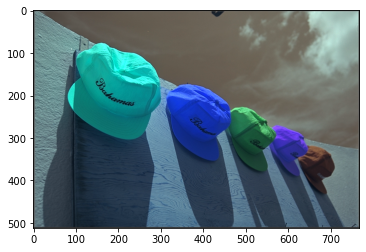

In [42]:
plt.imshow(original_image)

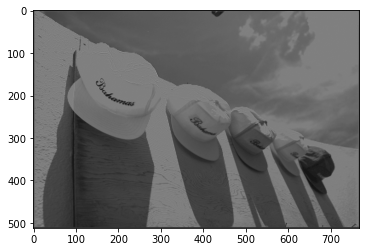

In [43]:
plt.imshow(recon_image)

In [44]:
print("Original Image Properties")
print("Shape: ", original_image.shape)
print("Size: ", original_image.size)
print("Data Type: ", original_image.dtype)
print("Max Value: ", original_image.max())
print("Min Value: ", original_image.min())
print("Dimensions: ", original_image.ndim)
print("Type: ", type(original_image))

Original Image Properties
Shape:  (512, 768, 3)
Size:  1179648
Data Type:  uint8
Max Value:  255
Min Value:  0
Dimensions:  3
Type:  <class 'numpy.ndarray'>


In [45]:
print("Reconstructed Image Properties")
print("Shape: ", recon_image.shape)
print("Size: ", recon_image.size)
print("Data Type: ", recon_image.dtype)
print("Max Value: ", recon_image.max())
print("Min Value: ", recon_image.min())
print("Dimensions: ", recon_image.ndim)
print("Type: ", type(recon_image))

Reconstructed Image Properties
Shape:  (512, 768, 3)
Size:  1179648
Data Type:  uint8
Max Value:  197
Min Value:  0
Dimensions:  3
Type:  <class 'numpy.ndarray'>


In [46]:
file_size_bytes_original = os.path.getsize(path_original_image)
file_size_bytes_recon = os.path.getsize(path_recon_image)
print("Size of Original Image:", file_size_bytes_original/2**20, "MB")
print("Size of Reconstructed Image:", file_size_bytes_recon/2**20, "MB")
print("Compression Ratio: ", file_size_bytes_original/file_size_bytes_recon)
print("Compression Ratio: ", file_size_bytes_recon/file_size_bytes_original)

Size of Original Image: 0.47959136962890625 MB
Size of Reconstructed Image: 0.17264366149902344 MB
Compression Ratio:  2.7779263105562615
Compression Ratio:  0.3599807511811775


In [47]:
height, width = original_image.shape[:2]
print("Dimensions of the original image:", height, "x", width)


height, width = recon_image.shape[:2]
print("Dimensions of the reconstructed image:", height, "x", width)

Dimensions of the original image: 512 x 768
Dimensions of the reconstructed image: 512 x 768


In [48]:
foreground_original_image = remove(original_image)
foreground_recon_image = remove(recon_image)

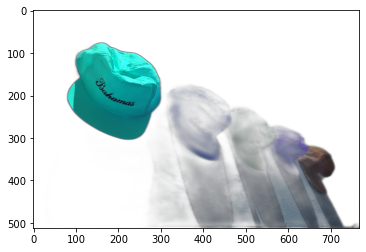

In [49]:
plt.imshow(foreground_original_image)

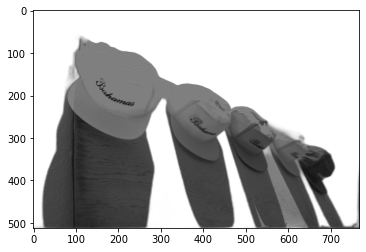

In [50]:
plt.imshow(foreground_recon_image)

In [51]:
print("Original Image Shape: ", original_image.shape)
print("Reconstructed Image Shape: ", recon_image.shape)

print("Foreground Original Image Shape: ", foreground_original_image.shape)
print("Foreground Reconstructed Image Shape: ", foreground_recon_image.shape)

Original Image Shape:  (512, 768, 3)
Reconstructed Image Shape:  (512, 768, 3)
Foreground Original Image Shape:  (512, 768, 4)
Foreground Reconstructed Image Shape:  (512, 768, 4)


In [52]:
foreground_original_image

array([[[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       ...,

       [[  0,   0,   0,   1],
        [  0,   0,   0,   1],
        [  0,   0,   0,   1],
        ...,
        [ 36,  37,  38,  93],
        [ 33,  33,  33,  86],
        [ 31,  31,  31,  81]],

       [[  1,   1,   1,   2],
        [  1,   1,   1,   2],
        [  0,   0,   0,   1],
        ...,
        [ 41,  41,  41, 106],
        [ 38,  38,  38,  98],
        [ 36,  36,  36,  93]],

       [[  0

In [53]:
foreground_recon_image

array([[[  3,   3,   3,   8],
        [  2,   2,   2,   6],
        [  2,   2,   2,   4],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  2,   2,   2,   5],
        [  2,   2,   2,   4],
        [  1,   1,   1,   3],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  1,   1,   1,   2],
        [  1,   1,   1,   2],
        [  1,   1,   1,   2],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       ...,

       [[  9,   9,   9,  24],
        [ 10,  10,  10,  27],
        [ 13,  13,  13,  33],
        ...,
        [ 58,  58,  58, 150],
        [ 54,  54,  54, 138],
        [ 50,  50,  50, 130]],

       [[ 13,  13,  13,  33],
        [ 14,  14,  14,  35],
        [ 16,  16,  16,  40],
        ...,
        [ 60,  60,  60, 152],
        [ 54,  54,  54, 140],
        [ 51,  51,  51, 132]],

       [[  0

In [54]:
foreground_original_image_ = foreground_original_image[:, :, :3]
foreground_recon_image_ = foreground_recon_image[:, :, :3]

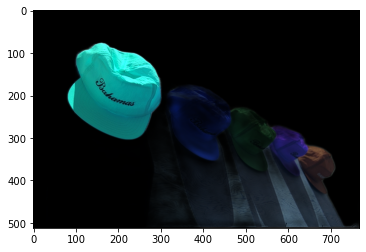

In [55]:
plt.imshow(foreground_original_image_)

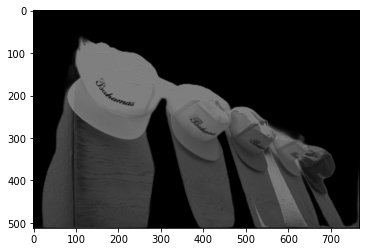

In [56]:
plt.imshow(foreground_recon_image_)

In [57]:
background_original_image = original_image - foreground_original_image_
background_recon_image = recon_image - foreground_recon_image_

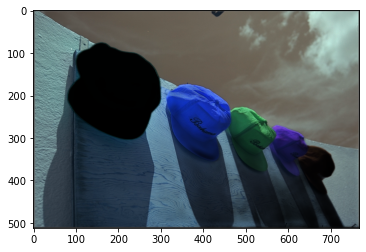

In [58]:
plt.imshow(background_original_image)

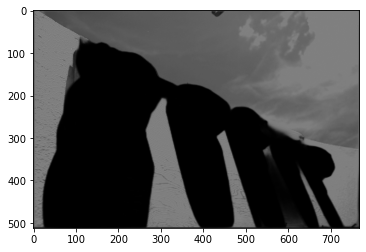

In [59]:
plt.imshow(background_recon_image)

In [80]:
def rle_encode(image):
    flattened_image = image.flatten()
    rle_data = []
    current_value = flattened_image[:3]  # Initialize with the first pixel RGB values
    run_length = 1

    for i in range(3, len(flattened_image), 3):
        pixel = flattened_image[i:i+3]
        if np.array_equal(pixel, current_value):
            run_length += 1
        else:
            rle_data.append((current_value, run_length))
            current_value = pixel
            run_length = 1

    # Add the last run
    rle_data.append((current_value, run_length))

    return rle_data

def rle_decode(rle_data, image_shape):
    reconstructed_image = np.zeros(image_shape, dtype=np.uint8)
    current_index = 0

    for value, run_length in rle_data:
        for _ in range(int(run_length)):
            reconstructed_image.flat[current_index:current_index + 3] = value
            current_index += 3

    return reconstructed_image.reshape(image_shape)

In [61]:
compressed_data_original = rle_encode(foreground_original_image_)
compressed_data_recon = rle_encode(foreground_recon_image_)

In [62]:
compressed_data_original

[(array([0, 0, 0], dtype=uint8), 56989),
 (array([1, 1, 1], dtype=uint8), 8),
 (array([0, 0, 0], dtype=uint8), 715),
 (array([0, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 17),
 (array([1, 1, 1], dtype=uint8), 5),
 (array([0, 0, 0], dtype=uint8), 10),
 (array([1, 1, 1], dtype=uint8), 6),
 (array([0, 0, 0], dtype=uint8), 1),
 (array([1, 1, 1], dtype=uint8), 2),
 (array([3, 3, 3], dtype=uint8), 1),
 (array([4, 5, 5], dtype=uint8), 1),
 (array([6, 6, 6], dtype=uint8), 1),
 (array([6, 7, 7], dtype=uint8), 1),
 (array([6, 8, 8], dtype=uint8), 1),
 (array([7, 9, 9], dtype=uint8), 1),
 (array([7, 9, 8], dtype=uint8), 1),
 (array([6, 7, 7], dtype=uint8), 1),
 (array([5, 5, 5], dtype=uint8), 1),
 (array([3, 3, 3], dtype=uint8), 1),
 (array([1, 1, 1], dtype=uint8), 1),
 (array([0, 0, 0], dtype=uint8), 3),
 (array([1, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 707),
 (array([0, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 17),
 (array([1, 1, 1], dtype=ui

In [63]:
compressed_data_recon

[(array([3, 3, 3], dtype=uint8), 1),
 (array([2, 2, 2], dtype=uint8), 2),
 (array([1, 1, 1], dtype=uint8), 1),
 (array([0, 0, 0], dtype=uint8), 764),
 (array([2, 2, 2], dtype=uint8), 2),
 (array([1, 1, 1], dtype=uint8), 2),
 (array([0, 0, 0], dtype=uint8), 764),
 (array([1, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 765),
 (array([1, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 765),
 (array([1, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 765),
 (array([1, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 765),
 (array([1, 1, 1], dtype=uint8), 3),
 (array([0, 0, 0], dtype=uint8), 765),
 (array([1, 1, 1], dtype=uint8), 4),
 (array([0, 0, 0], dtype=uint8), 764),
 (array([2, 2, 2], dtype=uint8), 3),
 (array([1, 1, 1], dtype=uint8), 2),
 (array([0, 0, 0], dtype=uint8), 1),
 (array([1, 1, 1], dtype=uint8), 1),
 (array([0, 0, 0], dtype=uint8), 761),
 (array([2, 2, 2], dtype=uint8), 3),
 (array([1, 1, 1], dtype=uint8), 2),
 (array([0, 0, 0], d

In [64]:
comp_fore_orignal = compressed_data_original.copy()
comp_fore_recon = compressed_data_recon.copy()

In [65]:
for i in range(len(comp_fore_orignal)):
  k,l = comp_fore_orignal[i]
  comp_fore_orignal[i] = np.append(comp_fore_orignal[i][0], l)

In [66]:
for i in range(len(comp_fore_recon)):
  k,l = comp_fore_recon[i]
  comp_fore_recon[i] = np.append(comp_fore_recon[i][0], l)

comp_fore_orignal = np.array(comp_fore_orignal)
comp_fore_recon = np.array(comp_fore_recon)

In [85]:
comp_fore_orignal.shape

(139317, 4)

In [86]:
comp_fore_recon.shape

(134794, 4)

In [69]:
plt.imsave("./output/compressed/compressed_foreground_original.png", comp_fore_orignal)
plt.imsave("./output/compressed/compressed_foreground_recon.png", comp_fore_recon)

In [70]:
cv2.imwrite("./output/compressed/foreground_original.jpg", foreground_original_image_)
cv2.imwrite("./output/compressed/foreground_recon.jpg", foreground_recon_image_)

True

In [71]:
file_size_bytes_foreground_original = os.path.getsize("./output/compressed/foreground_original.jpg")
file_size_bytes_foreground_recon = os.path.getsize("./output/compressed/foreground_recon.jpg")

print("File size of foreground original image: ", file_size_bytes_foreground_original/2**20, "MB")
print("File size of foreground recon image: ", file_size_bytes_foreground_recon/2**20, "MB")

File size of foreground original image:  0.04532432556152344 MB
File size of foreground recon image:  0.054739952087402344 MB


In [72]:
file_size_bytes_compressed_foreground_original = os.path.getsize("./output/compressed/compressed_foreground_original.png")
file_size_bytes_compressed_foreground_recon = os.path.getsize("./output/compressed/compressed_foreground_recon.png")

print("File size of compressed foreground original image: ", file_size_bytes_compressed_foreground_original/2**20, "MB")
print("File size of compressed foreground recon image: ", file_size_bytes_compressed_foreground_recon/2**20, "MB")

File size of compressed foreground original image:  0.009554862976074219 MB
File size of compressed foreground recon image:  0.011659622192382812 MB


In [73]:
compressed_foreground_original = plt.imread("./output/compressed/compressed_foreground_original.png")
compressed_foreground_recon = plt.imread("./output/compressed/compressed_foreground_recon.png")

In [74]:
read_compress_fore_orignal = []
for i in range(len(compressed_foreground_original)):
    k, l = compressed_foreground_original[i][0][:3], compressed_foreground_original[i][0][3]
    read_compress_fore_orignal.append((k, l))

In [75]:
read_compress_fore_recon = []
for i in range(len(compressed_foreground_recon)):
    k, l = compressed_foreground_recon[i][0][:3], compressed_foreground_recon[i][0][3]
    read_compress_fore_recon.append((k, l))

In [87]:
# Decompress the foreground image
reconstructed_foreground_original = rle_decode(read_compress_fore_orignal, foreground_original_image_.shape)
reconstructed_foreground_recon = rle_decode(read_compress_fore_recon, foreground_recon_image_.shape)

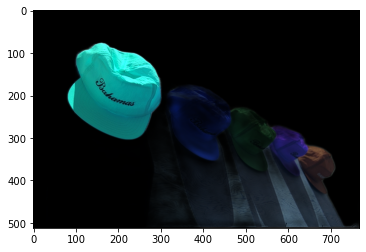

In [91]:
plt.imshow(reconstructed_foreground_original)

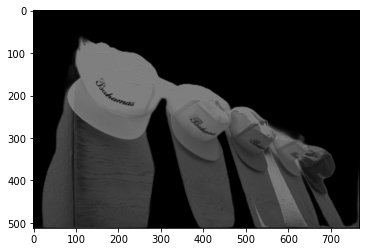

In [92]:
plt.imshow(reconstructed_foreground_recon)

In [93]:
cv2.imwrite("./output/compressed/reconstructed_foreground_original.jpg", reconstructed_foreground_original)

True

In [94]:
cv2.imwrite("./output/compressed/reconstructed_foreground_recon.jpg", reconstructed_foreground_recon)

True

In [95]:
file_size_bytes_reconstructed_foreground_original = os.path.getsize("./output/compressed/reconstructed_foreground_original.jpg")
file_size_bytes_reconstructed_foreground_recon = os.path.getsize("./output/compressed/reconstructed_foreground_recon.jpg")

print("File size of reconstructed foreground original image: ", file_size_bytes_reconstructed_foreground_original/2**20, "MB")
print("File size of reconstructed foreground recon image: ", file_size_bytes_reconstructed_foreground_recon/2**20, "MB")

File size of reconstructed foreground original image:  0.04532432556152344 MB
File size of reconstructed foreground recon image:  0.054739952087402344 MB


In [ ]:
class LZ77Compressor:
	MAX_WINDOW_SIZE = 400

	def __init__(self, window_size=20):
		self.window_size = min(window_size, self.MAX_WINDOW_SIZE)
		self.lookahead_buffer_size = 15 # length of match is at most 4 bits

	def compress(self, input_file_path, output_file_path=None, verbose=False):
		data = None
		i = 0
		output_buffer = bitarray(endian='big')

		# read the input file
		try:
			with open(input_file_path, 'rb') as input_file:
				data = input_file.read()
		except IOError:
			print('Could not open input file ...')
			raise

		while i < len(data):
			#print(i)

			match = self.findLongestMatch(data, i)

			if match:
				# Add 1 bit flag, followed by 12 bit for distance, and 4 bit for the length
				# of the match
				(bestMatchDistance, bestMatchLength) = match

				output_buffer.append(True)
				output_buffer.frombytes(bytes([bestMatchDistance >> 4]))
				output_buffer.frombytes(bytes([((bestMatchDistance & 0xf) << 4) | bestMatchLength]))

				if verbose:
					print("<1, %i, %i>" % (bestMatchDistance, bestMatchLength), end='')
				i += bestMatchLength

			else:
				# No useful match was found. Add 0 bit flag, followed by 8 bit for the character
				output_buffer.append(False)
				output_buffer.frombytes(bytes([data[i]]))

				if verbose:
					print("<0, %s>" % data[i], end='')
				i += 1

		# fill the buffer with zeros if the number of bits is not a multiple of 8
		output_buffer.fill()

		# write the compressed data into a binary file if a path is provided
		if output_file_path:
			try:
				with open(output_file_path, 'wb') as output_file:
					output_file.write(output_buffer.tobytes())
					print("File was compressed successfully and saved to output path ...")
					return None
			except IOError:
				print('Could not write to output file path. Please check if the path is correct ...')
				raise

		# an output file path was not provided, return the compressed data
		return output_buffer


	def decompress(self, input_file_path, output_file_path=None):
		"""
		Given a string of the compressed file path, the data is decompressed back to its
		original form, and written into the output file path if provided. If no output
		file path is provided, the decompressed data is returned as a string
		"""
		data = bitarray(endian='big')
		output_buffer = []

		# read the input file
		try:
			with open(input_file_path, 'rb') as input_file:
				data.fromfile(input_file)
		except IOError:
			print('Could not open input file ...')
			raise

		while len(data) >= 9:

			flag = data.pop(0)

			if not flag:
				byte = data[0:8].tobytes()

				output_buffer.append(byte)
				del data[0:8]
			else:
				byte1 = ord(data[0:8].tobytes())
				byte2 = ord(data[8:16].tobytes())

				del data[0:16]
				distance = (byte1 << 4) | (byte2 >> 4)
				length = (byte2 & 0xf)

				for i in range(length):
					output_buffer.append(output_buffer[-distance])
		out_data =  b''.join(output_buffer)

		if output_file_path:
			try:
				with open(output_file_path, 'wb') as output_file:
					output_file.write(out_data)
					print('File was decompressed successfully and saved to output path ...')
					return None
			except IOError:
				print('Could not write to output file path. Please check if the path is correct ...')
				raise
		return out_data


	def findLongestMatch(self, data, current_position):
		"""
		Finds the longest match to a substring starting at the current_position
		in the lookahead buffer from the history window
		"""
		end_of_buffer = min(current_position + self.lookahead_buffer_size, len(data) + 1)

		best_match_distance = -1
		best_match_length = -1

		# Optimization: Only consider substrings of length 2 and greater, and just
		# output any substring of length 1 (8 bits uncompressed is better than 13 bits
		# for the flag, distance, and length)
		for j in range(current_position + 2, end_of_buffer):

			start_index = max(0, current_position - self.window_size)
			substring = data[current_position:j]

			for i in range(start_index, current_position):

				repetitions = len(substring) // (current_position - i)

				last = len(substring) % (current_position - i)

				matched_string = data[i:current_position] * repetitions + data[i:i+last]

				if matched_string == substring and len(substring) > best_match_length:
					best_match_distance = current_position - i
					best_match_length = len(substring)

		if best_match_distance > 0 and best_match_length > 0:
			return (best_match_distance, best_match_length)
		return None